In [38]:
import pickle
from pathlib import Path

import arviz as az
from mubelnet.utils import  perplexity
from jax.tree_util import tree_map
from jaxtyping import Array, Float, UInt
import jax
import jax.numpy as jnp
from jax.scipy.stats import poisson
from matplotlib import pyplot as plt
from scipy.stats import entropy

from dataset import load_mutation_spectrum, COSMIC_WEIGHTS


X_train, X_test = load_mutation_spectrum()


MODEL = 'poisson_gamma_believe'
_bottom_layer_name = (
    f"{MODEL}/~/multinomial_layer"
    if MODEL == "multinomial_dirichlet_believe"
    else f"{MODEL}/~/poisson_layer"
)

In [2]:
state_dir = Path('/home/hylke/multdirbelnet/poisson_gamma_believe/38-78/samples')
pickles = sorted(state_dir.glob('sample_*.pkl'))
# Load the states from the pickles and concatenate along the second axis.
state_checkpoints = []
for p_file in pickles[-6:]:
    with open(p_file, 'rb') as fi:
        states = pickle.load(fi)
        states_thinned = tree_map(lambda x: x[:, ::5], states)
        del states
        state_checkpoints.append(states_thinned)

states = tree_map(lambda *xs: jnp.concatenate(xs, axis=1), *state_checkpoints)

In [3]:
def probability(state):
    bottom_state = state[_bottom_layer_name]
    phi = COSMIC_WEIGHTS.to_numpy()
    theta = bottom_state["copy[theta(1)]"]
    probs = theta @ phi
    probs /= probs.sum(axis=-1, keepdims=True)
    return probs

def rate(state):
    bottom_state = state[_bottom_layer_name]
    phi = COSMIC_WEIGHTS.to_numpy()
    theta = bottom_state["copy[theta(1)]"]
    return theta @ phi

def evaluate(params, states, X, axis=[0, 1]):
    """Compute perplexity over chains and samples by default (axis=[0, 1])."""
    probs = probability(params, states).mean(axis)
    return perplexity(X, probs)

In [35]:
def log_likelihood(
    x: UInt[Array, "batch features"],
    lambdas: Float[Array, "chains samples batch features"],
) -> Float[Array, "chains samples batch"]:
    ln_per_sample = jax.vmap(poisson.logpmf)
    ln_per_dataset = jax.vmap(ln_per_sample, in_axes=[None, 0])
    ln_per_chain = jax.vmap(ln_per_dataset, in_axes=[None, 0])
    return ln_per_chain(x, lambdas).sum(axis=-1)

In [36]:
lls = log_likelihood(X_test.astype(int), rate(states))
lls = jnp.mean(lls, axis=-1)  # Average over batch.

Text(0, 0.5, 'Log likelihood')

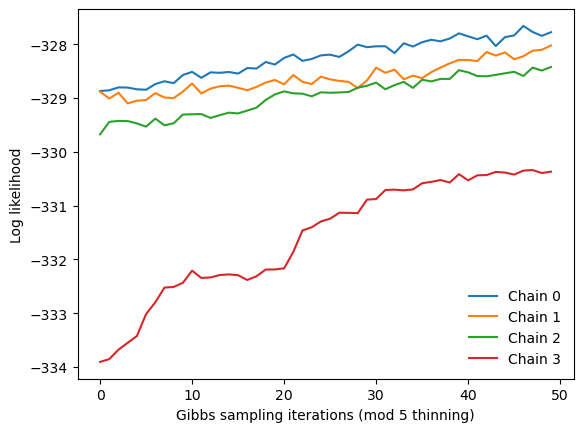

In [37]:
plt.plot(lls[0], label='Chain 0')
plt.plot(lls[1], label='Chain 1')
plt.plot(lls[2], label='Chain 2')
plt.plot(lls[3], label='Chain 3')
plt.legend(frameon=False)
plt.xlabel('Gibbs sampling iterations (mod 5 thinning)')
plt.ylabel('Log likelihood')

Evaluate performance

In [4]:
from statkit.non_parametric import bootstrap_score

probs = probability(states).mean(axis=[0, 1])
pp_estimate_1 = bootstrap_score(X_test, probs, metric=perplexity, random_state=42)
print("Perplexity on unseen observations", pp_estimate_1)
print(pp_estimate_1.latex())

Perplexity on unseen observations 6.19e+01 (95 % CI: 6.12e+01-6.25e+01)
6.19$^{+0.07}_{-0.07} \cdot 10^{1}$


In [5]:
# Convert states to arviz inference data.
r_entropy = entropy(states["poisson_gamma_believe/~/cap_layer"]["r"], axis=-1)
theta_1_entropy = entropy(states["poisson_gamma_believe/~/gamma_layer"]["theta"], axis=-1)
theta_2_entropy = entropy(states["poisson_gamma_believe/~/cap_layer"]["theta"], axis=-1)
phi_2_entropy = jnp.sum(entropy(states["poisson_gamma_believe/~/gamma_layer"]["phi"], axis=-1), axis=-1)
idata = az.convert_to_inference_data(
    {
        "c(2)": states["poisson_gamma_believe/~/cap_layer"]["c"],
        "c(1)": states["poisson_gamma_believe/~/gamma_layer"]["c"],
        "s[phi(2)]": phi_2_entropy,
        "s[r]": r_entropy,
        "s[theta(1)]": theta_1_entropy,
        "s[theta(2)]": theta_2_entropy,
    }
)

In [6]:
del states
isummary = az.summary(idata)
isummary

/home/hylke/.local/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


/home/hylke/.local/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<AxesSubplot:title={'center':'s[phi(2)]'}>,
        <AxesSubplot:title={'center':'s[phi(2)]'}>],
       [<AxesSubplot:title={'center':'s[r]'}>,
        <AxesSubplot:title={'center':'s[r]'}>]], dtype=object)

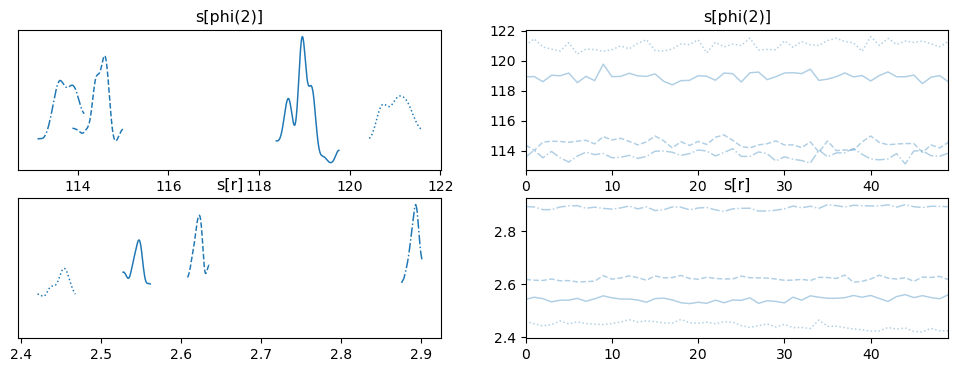

In [7]:
az.plot_trace(idata, var_names=["s[phi(2)]", "s[r]"])

In [8]:
theta_1_cols = [c_name for c_name in isummary.index if 'theta(1)' in c_name]
theta_2_cols = [c_name for c_name in isummary.index if 'theta(2)' in c_name]
c1_cols = [c_name for c_name in isummary.index if 'c(1)' in c_name]
c2_cols = [c_name for c_name in isummary.index if 'c(2)' in c_name]

In [9]:
isummary.loc[theta_1_cols]['r_hat'].describe()

count    4645.000000
mean        1.671901
std         0.383303
min         1.000000
25%         1.380000
50%         1.630000
75%         1.890000
max         3.720000
Name: r_hat, dtype: float64

In [10]:
isummary.loc[theta_2_cols]['r_hat'].describe()

count    4645.000000
mean        1.358304
std         0.260434
min         0.990000
25%         1.160000
50%         1.300000
75%         1.500000
max         2.680000
Name: r_hat, dtype: float64

In [11]:
isummary.loc[c1_cols]['r_hat'].describe()

count    4645.000000
mean        1.781653
std         0.470938
min         0.990000
25%         1.410000
50%         1.730000
75%         2.090000
max         3.640000
Name: r_hat, dtype: float64

In [12]:
isummary.loc[c2_cols]['r_hat'].describe()

count    4645.000000
mean        1.311948
std         0.231363
min         0.990000
25%         1.140000
50%         1.260000
75%         1.440000
max         2.570000
Name: r_hat, dtype: float64